In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("data/Telco-Customer-Churn.csv")

In [76]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [77]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
serv_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']
multi_cols = ['InternetService', 'Contract', 'PaymentMethod']

for col in binary_cols:
    if col == 'gender':
        df[col] = df[col].map({'Female': 0, 'Male': 1})
    else:
        df[col] = df[col].map({'No': 0, 'Yes': 1})

for col in serv_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})
    df[col] = df[col].map({'No': 0, 'Yes': 1})

df = pd.get_dummies(df, columns=multi_cols, drop_first=True, dtype=int)

df.drop('customerID', axis=1, inplace=True)

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

df['TotalCharges'] = df['TotalCharges'].fillna(0)

In [78]:
Y = df.pop("Churn").to_numpy()
X = df.to_numpy()

np.random.seed(42)

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

split_limit = int(0.8 * len(X))
train_idx, test_idx = indices[:split_limit], indices[split_limit:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = Y[train_idx], Y[test_idx]

In [79]:
Xmean = np.mean(X_train, axis=0)
Xdev = np.std(X_train, axis=0)
x_train = (X_train - Xmean) / (Xdev + 1e-8)

Xmean = np.mean(X_test, axis=0)
Xdev = np.std(X_test, axis=0)
x_test = (X_test - Xmean) / (Xdev + 1e-8)

In [80]:
def predict(X,w,b):
  z = np.dot(X,w) + b
  return 1 / (1 + np.exp(-z))

In [81]:
def classify(probabilities, threshold=0.5):
    return (probabilities >= threshold).astype(int)

In [82]:
def compute_cost(X,Y,w,b):
  total_cost = 0
  m = X.shape[0]
  epsilon = 1e-15
  for i in range(m):
    y_hat = predict(X[i], w, b)
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    loss = Y[i] * np.log(y_hat) + (1 - Y[i]) * np.log(1 - y_hat)
    total_cost -= loss
  return total_cost / m

In [ ]:
def compute_gradient(X,Y,w,b):
  m = X.shape[0]
  y_hat = predict(X,w,b)
  error = y_hat - Y
  dj_dw = (1/m) * np.dot(X.T, error)
  dj_db = (1/m) * np.sum(error)
  return dj_dw, dj_db

In [84]:
def gradient_descent(X,Y, epoches=1000, rate=0.1):
  m,n = X.shape
  w = np.zeros(n)
  cost_history = np.zeros(epoches)
  b = 0
  for i in range(epoches):
    cost_history[i] = compute_cost(X,Y,w,b)
    if i % 100 == 0:
      print(f"Epoch {i}: {cost_history[i]}")
    dj_dw, dj_db = compute_gradient(X,Y,w,b)
    w -= rate*dj_dw
    b -= rate*dj_db
  return w, b, cost_history

In [85]:
w, b, cost_history = gradient_descent(x_train, y_train)

Epoch 0: 0.6931471805600059
Epoch 100: 0.4321233944700577
Epoch 200: 0.42108146287110143
Epoch 300: 0.41881858040132564
Epoch 400: 0.41803398036705813
Epoch 500: 0.41763902067593267
Epoch 600: 0.41738324113412734
Epoch 700: 0.41719155691499094
Epoch 800: 0.4170359226167546
Epoch 900: 0.41690361305237245


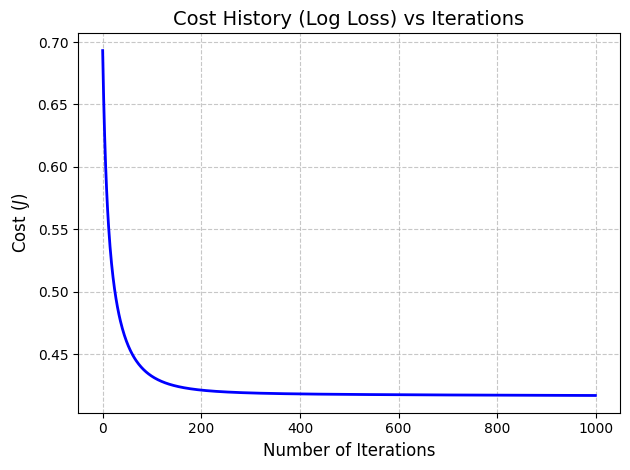

In [86]:
plt.plot(np.arange(0,1000), cost_history, color='blue', linewidth=2)
plt.title('Cost History (Log Loss) vs Iterations', fontsize=14)
plt.xlabel('Number of Iterations', fontsize=12)
plt.ylabel('Cost ($J$)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('cost_history_plot.png')

In [99]:
test_probs = predict(x_test, w, b)
test_preds = classify(test_probs, 0.5)

accuracy = np.mean(test_preds == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 80.41%
